## Movie review sentiment analysis

##### In this first example, we will use a pre-cleaned dataset of text snippets from movie reviews with sentiment classification, telling us if the snippet says something positive or negative about the movie.

##### We will first use BERT to convert the text snippets into embeddings which, in combination with the classifications, we will then use to train, validate, and test a simple neural network and compare the results to a logistic regression analysis of the same data sets.

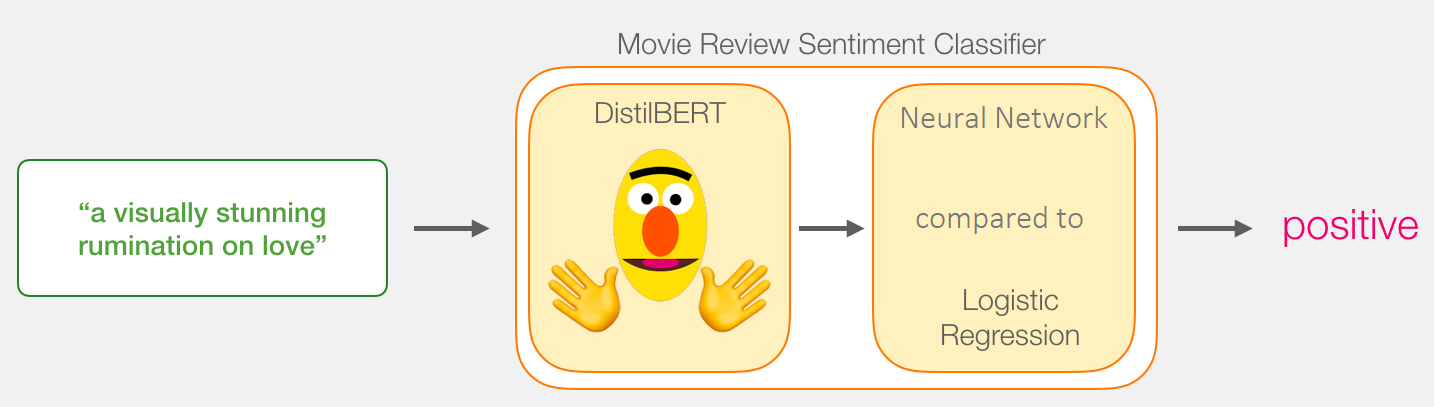

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename ="images/distilbert-bert-sentiment-classifier.png")

### DistilBERT
- compressed model
- 40 % less parameters than BERT (BERT Base has 110 million parameters)
- 60% faster
- preservin 99 % of BERT's performance

##### The logistic regression model is taken from the scikit-learn package; for the implementation of the neural network the pytorch package is used.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sample_size = 2000

#### Define functions which we can reuse, since we will do the same operations on multiple sub-datasets:
##### 1) Sample sentences need to be of a uniform length as BERT input. So we need to pad the token lists in a sample with zeros:

In [ ]:
def pad_token_list(sample):
    # Find the sentence with the max length
    max_len = 0
    for token_list in sample:
        if len(token_list) > max_len:
            max_len = len(token_list)
    # Adjust every sentence to the same length
    padded = np.array([token_list + [0]*(max_len-len(token_list)) for token_list in sample])
    return padded, max_len

##### 2) Extract embeddings from padded sample set. Conversion steps:
- (Pad the tokenized list of sample sentences)
- Create an attention mask where the padded tokens are identified with a 0 and the word tokens with a 1. This will help BERT distinguish between real data and padding
- Create pytorch tensor objects
- Feed the padded sample and the mask into BERT
- Extract the embedding vector for the [CLS] token of each sample point

In [ ]:
def get_embeddings_from_sample(sample, model):
    # Pad sample data:
#     sample = pad_token_list(sample)
    # Define mask from data: - 0 token entry     -> padding, set mask entry to 0
    #                        - non-0 token entry -> valid word, set mask entry to 1
    mask = np.where(sample != 0, 1, 0)
    
    # Create tensor objects from numpy arrays
    input_ids = torch.tensor(sample).long()
    attention_mask = torch.tensor(mask).long()

    # Use BERT model to get embeddings
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    # Extract [CLS] embedding for each sample as numpy array to be used for classification task
    features = last_hidden_states[0][:,0,:].numpy()
    return features, mask

##### We read in the data using pandas, since it is stored as csv

In [ ]:
dataset = pd.read_csv('./data/SST2/train.tsv',delimiter='\t',header=None,\
                           names=['sentence','label'])

##### Structure of the data:

In [ ]:
dataset.head()

##### Take a random sample from our dataset to use for training and validation

In [ ]:
random_sample = dataset.sample(n=sample_size)
random_sample.shape

##### We will use the rest as verification dataset to compare the to approaches

In [ ]:
test_set = dataset.iloc[dataset.index.difference(random_sample.index)]

##### Show distribution of positive and negative classifications in our random sample

In [ ]:
random_sample['label'].value_counts()

##### Load the pretrained, downsized version of BERT, DistilBERT:  
- We need a tokenizer, to split the snippets into single words and convert those into integers (word identifiers)
- We need the model itself to convert the word indentifiers into embedding vectors of size 768
- For both of those tasks, we need pre-trained weights

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

##### Apply tokenizer to both the sample and the test set

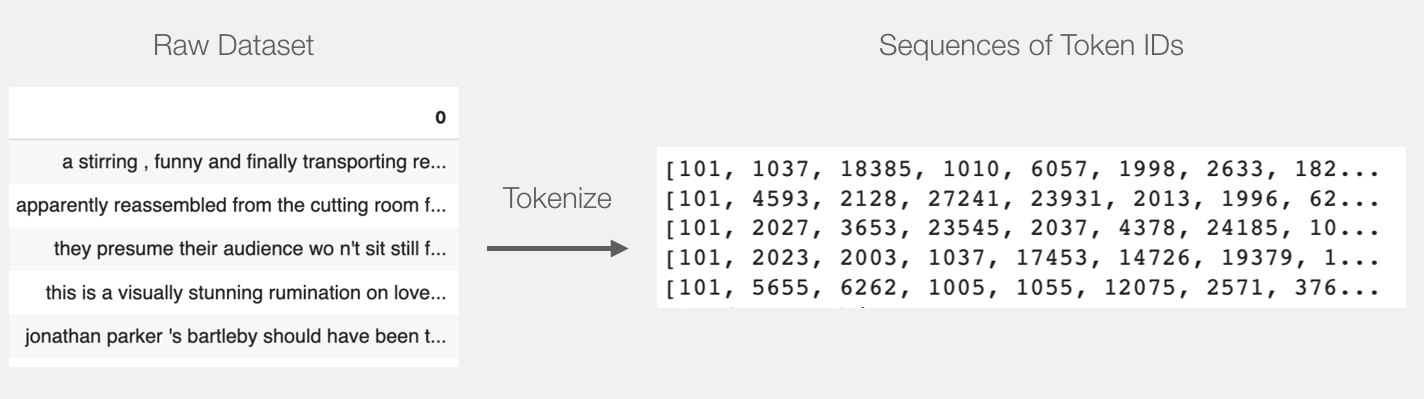

In [13]:
Image("images/sst2-text-to-tokenized-ids-bert-example.png")

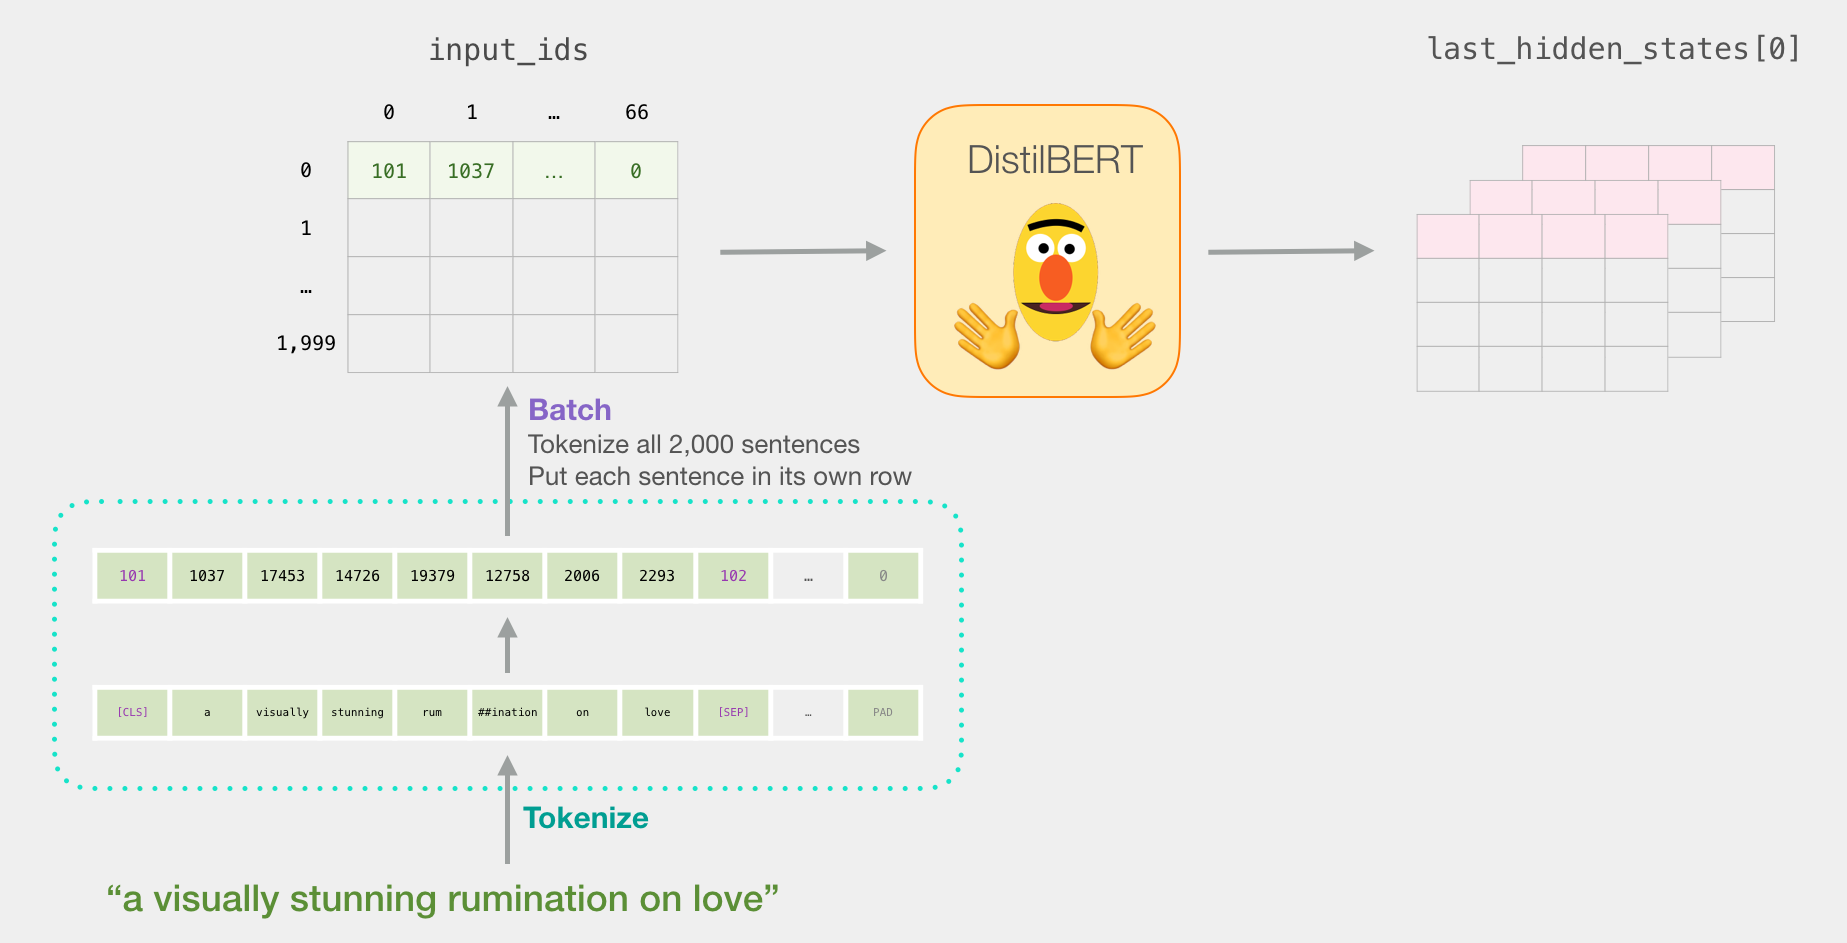

In [18]:
Image("images/bert-input-to-output-tensor-recap.png")

In [ ]:
sample_tokenized = random_sample['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
test_tokenized = test_set['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

##### Structure of tokenized snippets:  
##### The labels have not changed, but instead of one long string, we now have a list of single words as data.

In [ ]:
sample_tokenized.head()

##### To use BERT on this dataset, we need to have each snippet be of the same length. So we pad the shorter snippets with zeros at the end.

In [ ]:
sample_padded, sample_len = pad_token_list(sample_tokenized.values)
test_padded, test_len = pad_token_list(test_tokenized.values)

##### Structure of padded dataset:

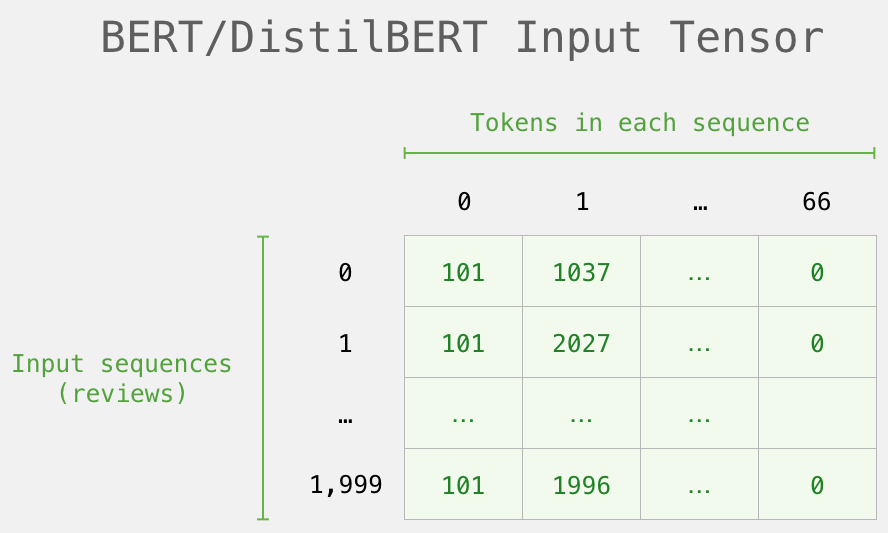

In [14]:
Image("images/bert-input-tensor.png")

In [ ]:
sample_padded[0]

##### Generate embeddings from sample data and extract [CLS] embedding which will be used for classification  

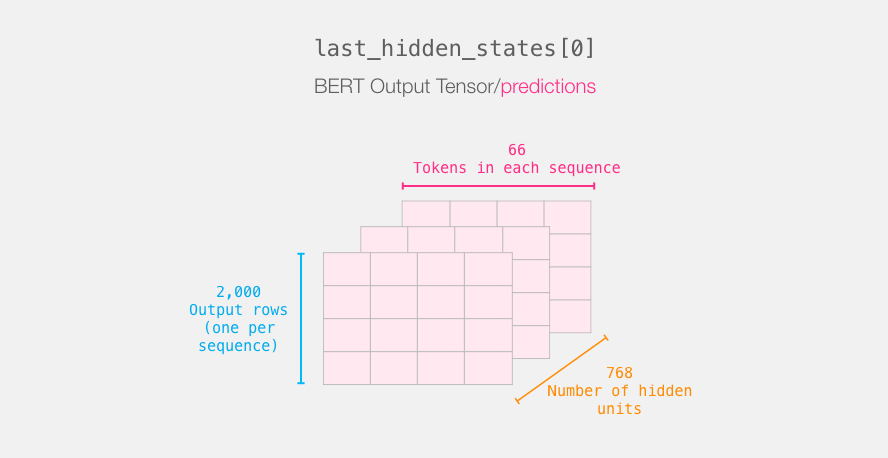

In [15]:
Image("images/bert-output-tensor.png")

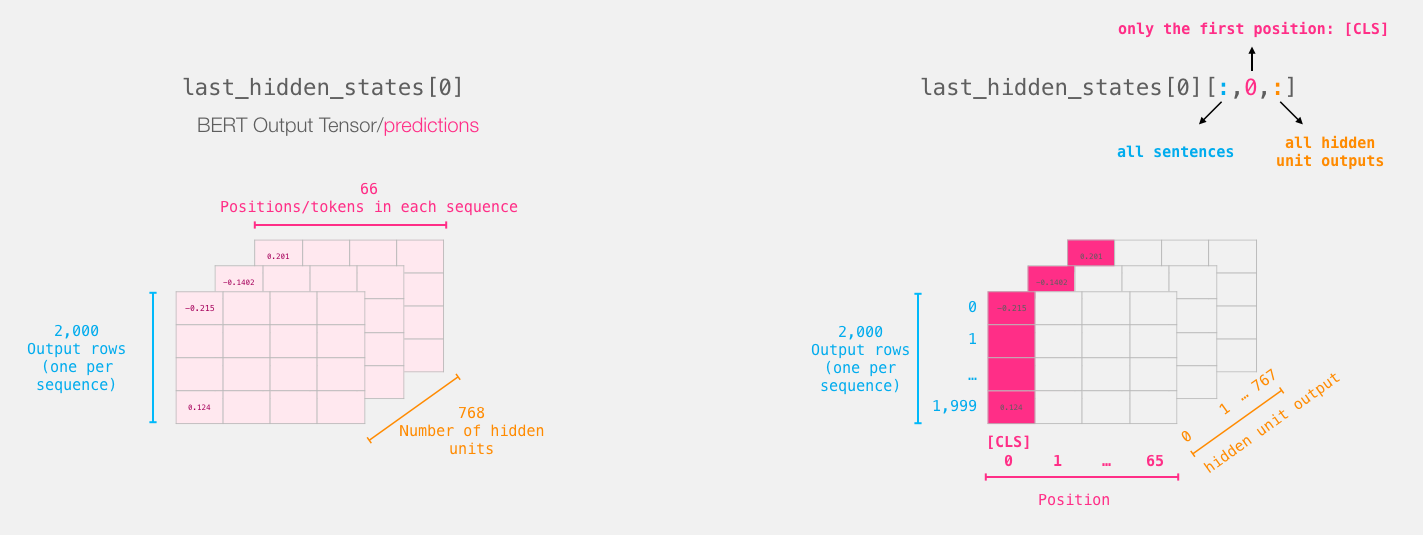

In [16]:
Image("images/bert-output-tensor-selection.png")

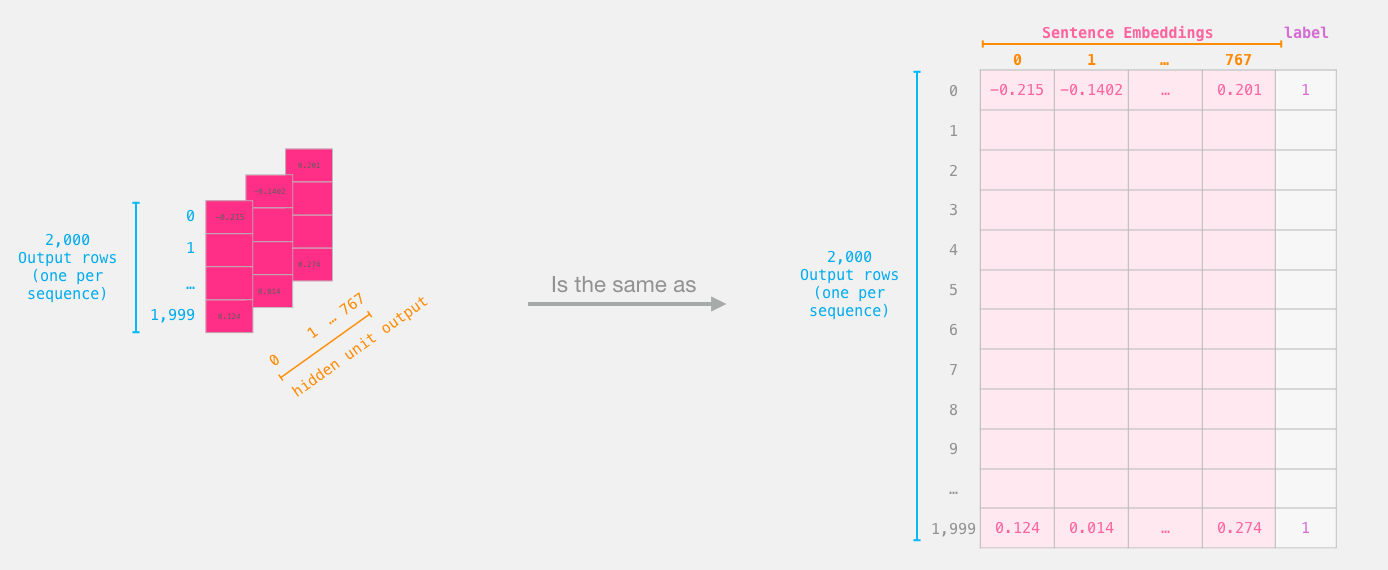

In [17]:
Image("images/bert-output-cls-senteence-embeddings.png")

##### The output shows the structure of the attention mask (for the first sample point) used in BERT to distinguish between real data and padding

In [ ]:
sample_features, mask = get_embeddings_from_sample(sample_padded, model)
mask[0]

##### Get embeddings for the test data

In [ ]:
test_features, mask = get_embeddings_from_sample(sample_padded)

##### Get sentiment classification labels for sample and test set from input

In [ ]:
sample_labels = random_sample['label']
test_labels = test_set['label']

##### Use scikit-learn's function train_test_split to randomly split up the sample into a training and a validation set

In [ ]:
train_features, val_features, train_labels, val_labels = train_test_split(sample_features, sample_labels)

##### By default, the data is split 75-25 into training and validation set

In [ ]:
len(train_features)

##### Create logistic regression model and feed it the training data

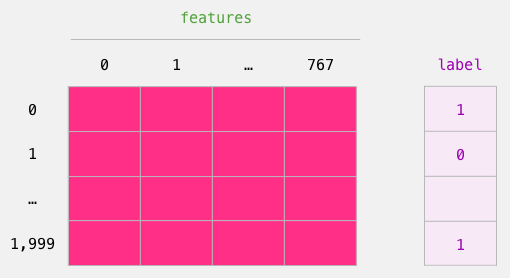

In [19]:
Image("images/logistic-regression-dataset-features-labels.png")

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

##### Show score of validation training set

In [ ]:
lr_clf.score(val_features, val_labels)

##### As a test for the regression model, we will use some tricky snippets where negative words are used for a positive review, and vice versa.  
##### Let's see how the model performs!

In [ ]:
# Let's feed it some of our own data (tricky!)
s = [['I hate people who hate this movie',1],
     ['I hate people who hate this movie, because I love it',1],
     ['I love people who do not love this movie',0],
     ['This movie is great',1]]
trick_sample = pd.DataFrame(data=s, columns=['sentence','label'])
trick_tokenized = trick_sample['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
trick_padded = pad_token_list(trick_tokenized.values)
trick_features, mask = get_embeddings_from_sample(trick_padded, model)

##### Show the predicted sentiment for the new reviews:

In [ ]:
lr_clf.predict(trick_features)

##### Compared to the manually assigned labels, we got 50% correct. Not bad!

### Let's create a neural net that gets equal or better results!

##### To speed up computation, we will perform the calculations on the graphics processor  
##### We need to create a device for that

In [ ]:
# Create cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#### Create tensor objects and transfer to device for all our data

In [ ]:
train_features_tensor = torch.tensor(np.asarray(train_features))
train_features_tensor = train_features_tensor.to(device)

val_features_tensor =  torch.tensor(np.asarray(val_features))
val_features_tensor = torch.tensor(val_features_tensor).to(device)

test_features_tensor =  torch.tensor(np.asarray(test_features))
test_features_tensor = torch.tensor(test_features_tensor).to(device)

trick_featues_tensor = torch.tensor(np.asarray(trick_features))
trick_features_tensor = torch.tensor(trick_features_tensor).to(device)

train_labels_tensor =  torch.tensor(np.asarray(train_labels))
train_labels_tensor = torch.tensor(train_labels_tensor).to(device)

val_labels_tensor = torch.tensor(np.asarray(val_labels))
val_labels_tensor = torch.tensor(val_labels_tensor).to(device)

test_labels_tensor = torch.tensor(np.asarray(test_labels))
test_labels_tensor = torch.tensor(test_labels_tensor).to(device)

trick_labels_tensor = torch.tensor(np.asarray(trick_sample['label']))
trick_labels_tensor = torch.tensor(trick_labels_tensor).to(device)

In [ ]:
train_features_tensor.shape

In [ ]:
# Put our input data onto device
last_hidden_states = last_hidden_states[0][:,0,:].to(device)

In [ ]:
last_hidden_states.size()

In [ ]:
# Define neural network class to be trained
# Structure:
# input -> fc1 -> sigmoid -> out -> log_softmax
import torch.nn as nn
import torch.nn.functional as F
class Shallow_Network(nn.Module):
    def __init__(self):
        super(Shallow_Network,self).__init__()
        self.fc1 = nn.Linear(768,1000)
        self.out = nn.Linear(1000,2)
    def forward(self,input):
        # Take input, feed through fc1 layer,
        # then apply activation function to it
        x = F.sigmoid(self.fc1(input))
        # Take output of sigmoid, input into out layer,
        # and apply log_softmax function
        return (F.log_softmax(self.out(x),dim=1))

In [ ]:
# Create neural network object
net = Shallow_Network()
net = net.to(device)

In [ ]:
# Export labels
labels_tensor = torch.tensor(labels.values)

In [ ]:
# Put on device
labels_tensor = labels_tensor.to(device)

In [ ]:
labels_tensor

In [ ]:
import torch.optim as optim
#Create an stochastic gradient descent optimizer
adam = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
loss_func.to(device)

In [ ]:
# Train network
cnt = 0
average_losses = []
average_val_losses = []
acc = []
cur_loss = []
min_validation = 10000.0
for epoch in range(1000):
    net.train()
    #zero the gradient
    adam.zero_grad()
    #Get output of network
    probs = net(train_features_tensor)
    #compute loss
    loss = loss_func(probs,train_labels_tensor)
    #compute the backward gradient and move network in that direction
    loss.backward()
    adam.step()
    #gather loss
    cur_loss.append(loss.detach().cpu().numpy())
    print("epoch ",epoch)
    print("training loss: ", np.mean(cur_loss))
    net.eval()
    probs_val = net(test_features_tensor)
    loss_val = loss_func(probs_val,test_labels_tensor)
    print("validation loss: ", np.mean(loss_val.detach().cpu().numpy()))
    #Save model if validation is min
    if min_validation > np.mean(loss_val.detach().cpu().numpy()):
        min_validation = np.mean(loss_val.detach().cpu().numpy())
        torch.save(net.state_dict(), './net_parameters_%d.pth' % epoch)
    

In [ ]:
model = Shallow_Network()
checkpoint = torch.load('./net_parameters_147.pth')
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

In [ ]:
probs_val = model(val_features_tensor)
loss_val = loss_func(probs_val,val_labels_tensor)
print("validation loss: ", np.mean(loss_val.detach().cpu().numpy()))

In [ ]:
# Get classification probabilities from hidden state array
# And apply Softmax
with torch.no_grad():
    probs = model(val_features_tensor)
    softprobs = F.softmax(probs)

In [ ]:
len(softprobs)

In [ ]:
# Get most likely class and its index for each sample point
values, indices = torch.max(softprobs,1)

In [ ]:
# Predicted labels
indices

In [ ]:
# Take original labels
labels_tensor

In [ ]:
# Calculate number of sample points where prediction failed
nums = torch.sum(torch.abs(val_labels_tensor-indices)).detach().cpu().numpy()

In [ ]:
# Number of correct predictions
numcorrect = 2000-(nums+0)

In [ ]:
# Accuracy of prediction
accuracy = numcorrect/2000

In [ ]:
accuracy

In [ ]:
idx = np.asarray(indices.detach().cpu().numpy())
lbls = np.asarray(labels_tensor.detach().cpu().numpy())

In [ ]:
new_df.iloc[np.where(idx-lbls)]

In [ ]:
# Using test set
probs_test = model(test_features_tensor)
loss_test = loss_func(probs_test,test_labels_tensor)
print("test loss: ", np.mean(loss_test.detach().cpu().numpy()))

In [ ]:
with torch.no_grad():
    probs_test = model(test_features_tensor)
    softprobs_test = F.softmax(probs_test)
# Get most likely class and its index for each sample point
test_values, test_indices = torch.max(softprobs_test,1)
# Calculate number of sample points where prediction failed
test_nums = torch.sum(torch.abs(test_labels_tensor-test_indices)).detach().cpu().numpy()
# Number of correct predictions
numcorrect = test_df.shape[0]-(test_nums+0)
# Accuracy of prediction
accuracy = numcorrect/test_df.shape[0]
print(accuracy)

In [ ]:
test_df.shape